In [ ]:
# Experiment 2: Fine-tuning BERT-base-uncased on Nigerian Pidgin Sentiment Dataset (GPU Version)
# This notebook implements the training procedure for the second experiment in our cross-lingual sentiment analysis project

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader

In [ ]:
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

In [ ]:
import os
import random
import re
!pip install emoji
import emoji
from tqdm.notebook import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 35.4 MB/s eta 0:00:00


In [ ]:
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# ## 1. Data Preparation

# Function to clean and normalize text
def clean_text(text, is_pidgin=False):
    """
    Clean and normalize text data

    Args:
        text (str): Input text
        is_pidgin (bool): Whether the text is Nigerian Pidgin

    Returns:
        str: Cleaned text
    """
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' [URL] ', text)

    # Remove user mentions (@username)
    text = re.sub(r'@\w+', ' [USER] ', text)

    # Handle hashtags - keep the text but remove the # symbol
    text = re.sub(r'#(\w+)', r'\1', text)

    # Convert emojis to text (alternatively, you can remove them)
    text = emoji.demojize(text)
    text = re.sub(r':[a-z_]+:', ' [EMOJI] ', text)  # replace with token or remove

    # Remove special characters but keep apostrophes (important for contractions)
    text = re.sub(r'[^a-zA-Z0-9\'\s]', ' ', text)

    # Normalize apostrophes
    text = text.replace("'", "'")

    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # For Pidgin-specific normalization
    if is_pidgin:
        # Define common Pidgin expressions to preserve
        pidgin_normalizations = {
            # Common variations
            " de ": " dey ",
            " sey ": " say ",
            " dem ": " them ",
            " una ": " you ",
            " dis ": " this ",
            " dat ": " that ",
            # Common expressions (keep intact)
            "abeg": "abeg",  # please
            "wetin": "wetin",  # what
            "na ": "na ",  # is/it is
            "abi": "abi",  # right?/isn't it?
            "shey": "shey",  # is it that
            "sha": "sha",  # anyway/though
            "wahala": "wahala",  # trouble
            "japa": "japa",  # run away/leave
            "gats": "gats",  # must/have to
        }

        for old, new in pidgin_normalizations.items():
            text = text.replace(old, new)

    return text.strip()


In [ ]:
# Custom dataset class
class SentimentDataset(Dataset):
    """PyTorch dataset for sentiment analysis"""
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Remove the batch dimension which tokenizer adds by default
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding['labels'] = torch.tensor(label)

        return encoding


In [ ]:
# Load and prepare datasets
print("Loading datasets...")

Loading datasets...


In [ ]:
# Load Pidgin dataset as the primary training set for Experiment 2
pidgin_df = pd.read_csv('new_annotated_pidgin.csv')
print(f"Pidgin dataset shape: {pidgin_df.shape}")


Pidgin dataset shape: (5000, 2)


In [ ]:
# Map sentiments to numeric values
sentiment_map = {'positive': 0, 'negative': 1, 'neutral': 2}
pidgin_df['label'] = pidgin_df['sentiments'].map(sentiment_map)

In [ ]:
# Clean text
pidgin_df['cleaned_text'] = pidgin_df['Comments'].apply(lambda x: clean_text(x, is_pidgin=True))

In [ ]:
# Check sentiment distribution
sentiment_counts = pidgin_df['sentiments'].value_counts()
print("\nPidgin sentiment distribution:")
print(sentiment_counts)
print(f"Percentages: {sentiment_counts / len(pidgin_df) * 100}")


Pidgin sentiment distribution:
sentiments
negative    3099
neutral     1362
positive     539
Name: count, dtype: int64
Percentages: sentiments
negative    61.98
neutral     27.24
positive    10.78
Name: count, dtype: float64


In [ ]:
# Load English dataset for testing
english_df = pd.read_csv('English_dataset.csv')
print(f"\nEnglish dataset shape: {english_df.shape}")
english_df['label'] = english_df['Sentiments'].map(sentiment_map)
english_df['cleaned_text'] = english_df['text'].apply(lambda x: clean_text(x, is_pidgin=False))


English dataset shape: (10000, 2)


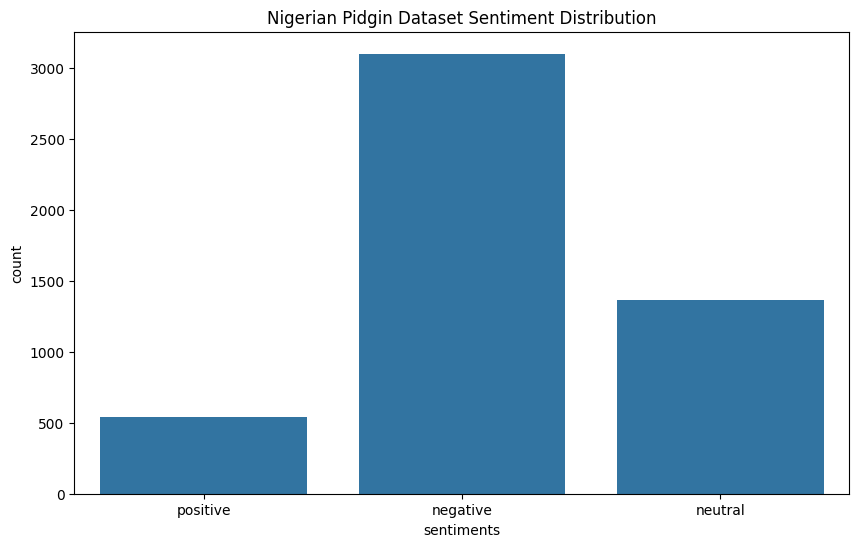

In [ ]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiments', data=pidgin_df)
plt.title('Nigerian Pidgin Dataset Sentiment Distribution')
plt.show()

In [ ]:
# ## 2. Split Datasets

from sklearn.model_selection import train_test_split

# Split into train, validation, and test sets
def split_dataset(df, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Split dataset into train, validation, and test sets with stratification
    """
    # First split: train + validation and test
    train_val, test = train_test_split(
        df, test_size=test_size, random_state=random_state, stratify=df['label']
    )

    # Second split: train and validation
    # Adjust validation size relative to train_val
    relative_val_size = val_size / (train_size + val_size)
    train, val = train_test_split(
        train_val, test_size=relative_val_size, random_state=random_state,
        stratify=train_val['label']
    )

    return train, val, test

In [ ]:
# Split Pidgin dataset
pidgin_train, pidgin_val, pidgin_test = split_dataset(pidgin_df)

In [ ]:
# Display split sizes
print("\nDataset splits:")
print(f"Pidgin - Train: {len(pidgin_train)}, Val: {len(pidgin_val)}, Test: {len(pidgin_test)}")


Dataset splits:
Pidgin - Train: 3500, Val: 750, Test: 750


In [ ]:
# Check class distribution in splits
print("\nTrain distribution:")
print(pidgin_train['sentiments'].value_counts())
print("\nValidation distribution:")
print(pidgin_val['sentiments'].value_counts())
print("\nTest distribution:")
print(pidgin_test['sentiments'].value_counts())


Train distribution:
sentiments
negative    2169
neutral      954
positive     377
Name: count, dtype: int64

Validation distribution:
sentiments
negative    465
neutral     204
positive     81
Name: count, dtype: int64

Test distribution:
sentiments
negative    465
neutral     204
positive     81
Name: count, dtype: int64


In [ ]:
# Sample English test data
english_test = english_df.sample(1500, random_state=42)  # As specified in experiment design
print(f"\nEnglish test set size: {len(english_test)}")
print("English test distribution:")
print(english_test['Sentiments'].value_counts())


English test set size: 1500
English test distribution:
Sentiments
positive    1149
negative     347
neutral        4
Name: count, dtype: int64


In [ ]:
# Check for class imbalance in Pidgin
print("\nChecking for class imbalance in Pidgin training data:")
print(pidgin_train['sentiments'].value_counts(normalize=True) * 100)


Checking for class imbalance in Pidgin training data:
sentiments
negative    61.971429
neutral     27.257143
positive    10.771429
Name: proportion, dtype: float64


In [ ]:
# ## 3. Address Class Imbalance

# The Pidgin dataset is now skewed toward negative sentiment (3099 samples)
# with fewer positive samples (539) and moderate neutral samples (1362)
# We'll implement class weighting to address this during training

def compute_class_weights(labels):
    """Compute class weights inversely proportional to class frequencies"""
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / (len(class_counts) * class_counts)

    # Ensure we have weights for all 3 classes (positive, negative, neutral)
    if len(class_weights) < 3:
        # If some class is missing in the bincount, add zeros
        pad_length = 3 - len(class_weights)
        class_weights = np.pad(class_weights, (0, pad_length), 'constant')

    return torch.FloatTensor(class_weights)

# Print actual class counts for verification
print("\nActual class counts in training data:")
print(pidgin_train['label'].value_counts().sort_index())

class_weights = compute_class_weights(pidgin_train['label'].values)
print("\nComputed class weights for handling imbalance:")
print(f"Positive (0): {class_weights[0]:.4f}")
print(f"Negative (1): {class_weights[1]:.4f}")
print(f"Neutral (2): {class_weights[2]:.4f}")


Actual class counts in training data:
label
0     377
1    2169
2     954
Name: count, dtype: int64

Computed class weights for handling imbalance:
Positive (0): 3.0946
Negative (1): 0.5379
Neutral (2): 1.2229


In [ ]:
# ## 4. Initialize Tokenizer

# Initialize and enhance BERT tokenizer for better Pidgin handling
def enhance_tokenizer_for_pidgin(tokenizer):
    """Enhance tokenizer with Nigerian Pidgin specific tokens"""
    # Common Pidgin expressions to add as special tokens
    pidgin_special_tokens = {
        'additional_special_tokens': [
            '[ABEG]', '[WETIN]', '[DEY]', '[NA]', '[SHEY]', '[ABI]',
            '[WAHALA]', '[SHA]', '[SABI]', '[JAPA]', '[GATS]'
        ]
    }

    # Add special tokens
    num_added = tokenizer.add_special_tokens(pidgin_special_tokens)
    print(f"Added {num_added} special tokens to tokenizer")

    return tokenizer

In [ ]:
# Initialize the tokenizer
print("Initializing tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = enhance_tokenizer_for_pidgin(tokenizer)

Initializing tokenizer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Added 11 special tokens to tokenizer


In [ ]:
# Determine optimal sequence length
def analyze_token_lengths(texts, tokenizer, percentile=95):
    """Analyze token length distribution and determine max length"""
    token_lengths = []
    for text in tqdm(texts, desc="Analyzing token lengths"):
        if isinstance(text, str) and text.strip():
            tokens = tokenizer.tokenize(text)
            token_lengths.append(len(tokens))

    # Calculate statistics
    mean_len = np.mean(token_lengths)
    median_len = np.median(token_lengths)
    p95 = np.percentile(token_lengths, percentile)
    max_len = np.max(token_lengths)

    # Round up to nearest multiple of 8 for efficiency
    recommended_length = ((int(p95) + 7) // 8) * 8

    print(f"Token length statistics:")
    print(f"Mean: {mean_len:.1f}")
    print(f"Median: {median_len:.1f}")
    print(f"95th percentile: {p95:.1f}")
    print(f"Max: {max_len}")
    print(f"Recommended max_length: {recommended_length}")

    return recommended_length, token_lengths

In [ ]:
# Analyze Pidgin and English token lengths
print("\nAnalyzing Pidgin token lengths...")
pidgin_sample = pidgin_train['cleaned_text'].sample(500, random_state=42).tolist()
max_length_pidgin, pidgin_lengths = analyze_token_lengths(pidgin_sample, tokenizer)


Analyzing Pidgin token lengths...


Analyzing token lengths:   0%|          | 0/500 [00:00<?, ?it/s]

Token length statistics:
Mean: 42.1
Median: 28.0
95th percentile: 119.0
Max: 422
Recommended max_length: 120


In [ ]:
print("\nAnalyzing English token lengths...")
english_sample = english_test['cleaned_text'].sample(500, random_state=42).tolist()
max_length_english, english_lengths = analyze_token_lengths(english_sample, tokenizer)


Analyzing English token lengths...


Analyzing token lengths:   0%|          | 0/500 [00:00<?, ?it/s]

Token length statistics:
Mean: 33.2
Median: 20.0
95th percentile: 101.0
Max: 440
Recommended max_length: 104


In [ ]:
# Use the maximum of both for test data to handle both languages
max_length_test = max(max_length_english, max_length_pidgin)

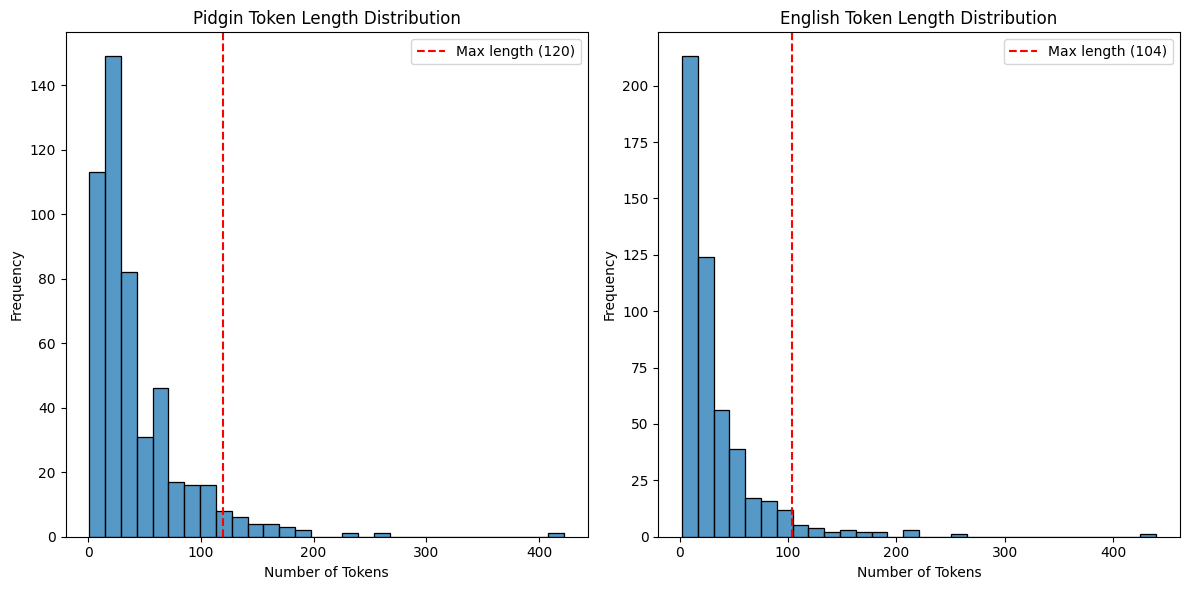

In [ ]:
# Visualize token length distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(pidgin_lengths, bins=30)
plt.axvline(x=max_length_pidgin, color='r', linestyle='--', label=f'Max length ({max_length_pidgin})')
plt.title('Pidgin Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(english_lengths, bins=30)
plt.axvline(x=max_length_english, color='r', linestyle='--', label=f'Max length ({max_length_english})')
plt.title('English Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# ## 5. Create PyTorch Datasets

# Prepare datasets
print("Creating PyTorch datasets...")

# Training dataset
train_dataset = SentimentDataset(
    pidgin_train['cleaned_text'].tolist(),
    pidgin_train['label'].tolist(),
    tokenizer,
    max_length=max_length_pidgin
)

# Validation dataset
val_dataset = SentimentDataset(
    pidgin_val['cleaned_text'].tolist(),
    pidgin_val['label'].tolist(),
    tokenizer,
    max_length=max_length_pidgin
)

# Test datasets (separate for English and Pidgin for cross-lingual evaluation)
pidgin_test_dataset = SentimentDataset(
    pidgin_test['cleaned_text'].tolist(),
    pidgin_test['label'].tolist(),
    tokenizer,
    max_length=max_length_test  # Use longer sequence length for test
)

english_test_dataset = SentimentDataset(
    english_test['cleaned_text'].tolist(),
    english_test['label'].tolist(),
    tokenizer,
    max_length=max_length_test  # Use longer sequence length for test
)

# Combined test dataset
combined_test_texts = pidgin_test['cleaned_text'].tolist() + english_test['cleaned_text'].tolist()
combined_test_labels = pidgin_test['label'].tolist() + english_test['label'].tolist()

combined_test_dataset = SentimentDataset(
    combined_test_texts,
    combined_test_labels,
    tokenizer,
    max_length=max_length_test
)

Creating PyTorch datasets...


In [ ]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Pidgin test dataset size: {len(pidgin_test_dataset)}")
print(f"English test dataset size: {len(english_test_dataset)}")
print(f"Combined test dataset size: {len(combined_test_dataset)}")

# Check example batch
train_batch = next(iter(DataLoader(train_dataset, batch_size=2)))
print("\nExample batch keys:", train_batch.keys())
print(f"Input IDs shape: {train_batch['input_ids'].shape}")
print(f"Attention mask shape: {train_batch['attention_mask'].shape}")
print(f"Labels: {train_batch['labels']}")

Train dataset size: 3500
Validation dataset size: 750
Pidgin test dataset size: 750
English test dataset size: 1500
Combined test dataset size: 2250

Example batch keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
Input IDs shape: torch.Size([2, 120])
Attention mask shape: torch.Size([2, 120])
Labels: tensor([1, 1])


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# ## 6. Model Setup and Training

# Define metrics function
def compute_metrics(pred):
    """Compute metrics for evaluation"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# Define a custom loss function that applies class weights
class WeightedBertForSequenceClassification(BertForSequenceClassification):
    def __init__(self, config, class_weights=None):
        super().__init__(config)
        self.class_weights = class_weights

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None,
                labels=None, output_attentions=None, output_hidden_states=None,
                return_dict=None):

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None and self.class_weights is not None:
            # Apply class weights to cross entropy loss
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        from transformers.modeling_outputs import SequenceClassifierOutput
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
# Initialize model
print("\nInitializing model...")
# Use the custom model with class weights
model = WeightedBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,  # positive, negative, neutral
    class_weights=class_weights
)


Initializing model...


Some weights of WeightedBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Resize token embeddings to account for new tokens
model.resize_token_embeddings(len(tokenizer))

Embedding(30533, 768, padding_idx=0)

In [ ]:
# Move model to GPU if available
model.to(device)

WeightedBertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30533, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

In [ ]:
# Training arguments
print("\nSetting up training arguments...")
training_args = TrainingArguments(
    output_dir="./results/exp2",
    num_train_epochs=5,
    per_device_train_batch_size=16,  # Can increase if GPU memory allows
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs/exp2",
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU is available
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Setting up training arguments...


In [ ]:
# Initialize Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


In [ ]:
# ## 7. Train Model

# Train the model
print("\nTraining the model...")
trainer.train()



Training the model...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.045700,0.957552,0.577333,0.621342,0.726884,0.577333
2,0.784600,0.591299,0.790667,0.799973,0.822984,0.790667
3,0.557400,0.714303,0.832000,0.829992,0.830326,0.832000
4,0.355400,0.740698,0.848000,0.845783,0.845088,0.848000
5,0.190500,0.836408,0.856000,0.855343,0.856768,0.856000


TrainOutput(global_step=1095, training_loss=0.5744386577170734, metrics={'train_runtime': 168.5019, 'train_samples_per_second': 103.856, 'train_steps_per_second': 6.498, 'total_flos': 1079176127400000.0, 'train_loss': 0.5744386577170734, 'epoch': 5.0})

In [ ]:
# Save the final model
print("\nSaving the best model...")
trainer.save_model("./results/exp2/best_model")
tokenizer.save_pretrained("./results/exp2/tokenizer")



Saving the best model...


('./results/exp2/tokenizer/tokenizer_config.json',
 './results/exp2/tokenizer/special_tokens_map.json',
 './results/exp2/tokenizer/vocab.txt',
 './results/exp2/tokenizer/added_tokens.json')

In [ ]:
# ## 8. Evaluation

# Evaluate on validation set
print("\nEvaluating on validation set...")
val_results = trainer.evaluate(val_dataset)
print(f"Validation results: {val_results}")

# Evaluate on Pidgin test set
print("\nEvaluating on Pidgin test set (in-language performance)...")
pidgin_test_results = trainer.evaluate(pidgin_test_dataset)
print(f"Pidgin test results: {pidgin_test_results}")

# Evaluate on English test set
print("\nEvaluating on English test set (cross-lingual performance)...")
english_test_results = trainer.evaluate(english_test_dataset)
print(f"English test results: {english_test_results}")

# Evaluate on combined test set
print("\nEvaluating on combined test set...")
combined_test_results = trainer.evaluate(combined_test_dataset)
print(f"Combined test results: {combined_test_results}")


Evaluating on validation set...


Validation results: {'eval_loss': 0.8364084362983704, 'eval_accuracy': 0.856, 'eval_f1': 0.8553432891776795, 'eval_precision': 0.8567684953024457, 'eval_recall': 0.856, 'eval_runtime': 1.7643, 'eval_samples_per_second': 425.091, 'eval_steps_per_second': 13.603, 'epoch': 5.0}

Evaluating on Pidgin test set (in-language performance)...
Pidgin test results: {'eval_loss': 0.8371557593345642, 'eval_accuracy': 0.848, 'eval_f1': 0.8491946310982936, 'eval_precision': 0.8538073468858413, 'eval_recall': 0.848, 'eval_runtime': 1.6063, 'eval_samples_per_second': 466.912, 'eval_steps_per_second': 14.941, 'epoch': 5.0}

Evaluating on English test set (cross-lingual performance)...
English test results: {'eval_loss': 1.8620436191558838, 'eval_accuracy': 0.516, 'eval_f1': 0.6485062681582919, 'eval_precision': 0.8817514592215483, 'eval_recall': 0.516, 'eval_runtime': 3.0576, 'eval_samples_per_second': 490.574, 'eval_steps_per_second': 15.371, 'epoch': 5.0}

Evaluating on combined test set...
Combined t

In [ ]:
# ## 9. Detailed Performance Analysis

# Get predictions for the test sets
def get_predictions(model, dataset, device):
    """Get model predictions for a dataset"""
    dataloader = DataLoader(dataset, batch_size=16)
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting predictions"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**{k: v for k, v in batch.items() if k != 'labels'})

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    return np.array(all_preds), np.array(all_labels)


In [ ]:
# Get predictions
pidgin_preds, pidgin_labels = get_predictions(model, pidgin_test_dataset, device)
english_preds, english_labels = get_predictions(model, english_test_dataset, device)


Getting predictions:   0%|          | 0/47 [00:00<?, ?it/s]

Getting predictions:   0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
# Detailed metrics
def print_detailed_metrics(preds, labels, dataset_name):
    """Print detailed metrics for a dataset"""
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    print(f"\n{dataset_name} Detailed Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")

    # Classification report
    label_names = ['positive', 'negative', 'neutral']
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=label_names))

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



Pidgin Test Detailed Metrics:
Accuracy: 0.8480
F1 Score (weighted): 0.8492
Precision (weighted): 0.8538
Recall (weighted): 0.8480

Classification Report:
              precision    recall  f1-score   support

    positive       0.78      0.67      0.72        81
    negative       0.92      0.89      0.91       465
     neutral       0.72      0.83      0.77       204

    accuracy                           0.85       750
   macro avg       0.81      0.79      0.80       750
weighted avg       0.85      0.85      0.85       750



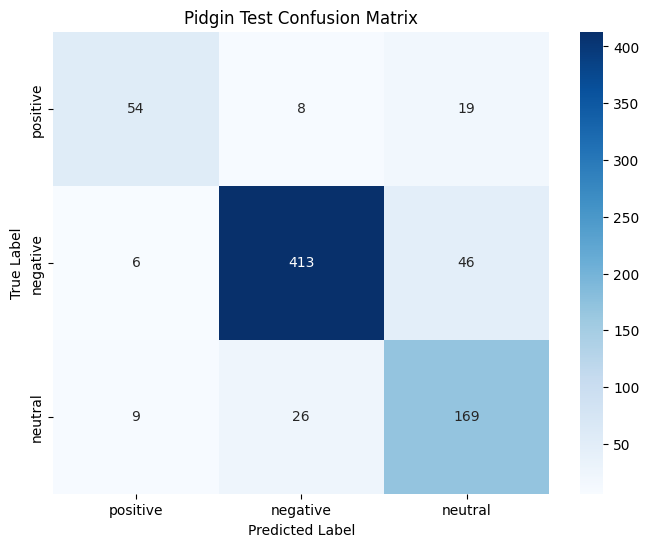


English Test (Cross-lingual) Detailed Metrics:
Accuracy: 0.5160
F1 Score (weighted): 0.6485
Precision (weighted): 0.8818
Recall (weighted): 0.5160

Classification Report:
              precision    recall  f1-score   support

    positive       0.94      0.57      0.71      1149
    negative       0.69      0.33      0.45       347
     neutral       0.00      0.75      0.01         4

    accuracy                           0.52      1500
   macro avg       0.54      0.55      0.39      1500
weighted avg       0.88      0.52      0.65      1500



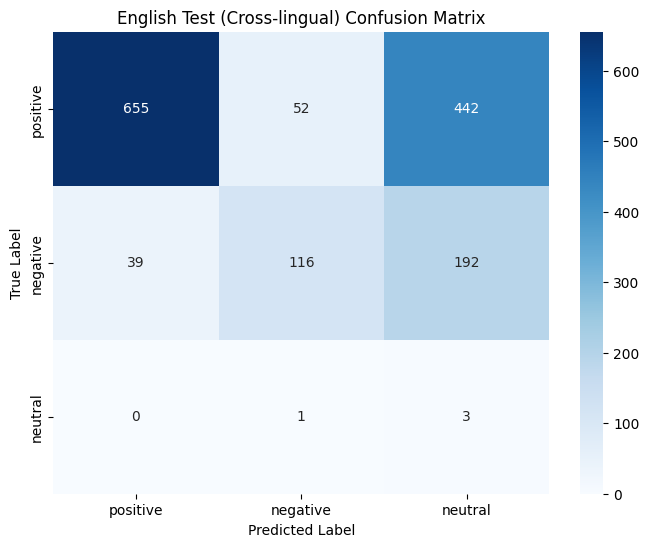

In [ ]:
# Print detailed metrics
print_detailed_metrics(pidgin_preds, pidgin_labels, "Pidgin Test")
print_detailed_metrics(english_preds, english_labels, "English Test (Cross-lingual)")


In [ ]:
# ## 10. Analyze Error Cases

# Function to analyze error cases
def analyze_errors(texts, preds, labels, dataset_name, max_examples=10):
    """Analyze and display error cases"""
    errors = []
    for i in range(len(texts)):
        if preds[i] != labels[i]:
            errors.append({
                'text': texts[i],
                'true_label': labels[i],
                'pred_label': preds[i]
            })

    print(f"\n{dataset_name} Error Analysis ({len(errors)} errors out of {len(texts)} samples):")
    print(f"Error rate: {len(errors)/len(texts):.2%}")

    # Group errors by type
    error_types = {}
    for error in errors:
        key = f"{error['true_label']} -> {error['pred_label']}"
        if key not in error_types:
            error_types[key] = []
        error_types[key].append(error)

    # Print error distribution
    print("\nError distribution:")
    for error_type, examples in error_types.items():
        true_label, pred_label = error_type.split(' -> ')
        label_map_inv = {0: 'positive', 1: 'negative', 2: 'neutral'}
        true_name = label_map_inv[int(true_label)]
        pred_name = label_map_inv[int(pred_label)]
        print(f"  {true_name} predicted as {pred_name}: {len(examples)} cases ({len(examples)/len(errors):.2%} of errors)")

    # Show examples of each error type
    print("\nExample errors by type:")
    for error_type, examples in error_types.items():
        true_label, pred_label = error_type.split(' -> ')
        label_map_inv = {0: 'positive', 1: 'negative', 2: 'neutral'}
        true_name = label_map_inv[int(true_label)]
        pred_name = label_map_inv[int(pred_label)]

        print(f"\n{true_name} predicted as {pred_name}:")
        for i, error in enumerate(examples[:max_examples]):
            print(f"  Example {i+1}: {error['text']}")

In [ ]:
# Analyze Pidgin errors
analyze_errors(
    pidgin_test['cleaned_text'].tolist(),
    pidgin_preds,
    pidgin_labels,
    "Pidgin Test"
)


Pidgin Test Error Analysis (114 errors out of 750 samples):
Error rate: 15.20%

Error distribution:
  positive predicted as negative: 8 cases (7.02% of errors)
  neutral predicted as negative: 26 cases (22.81% of errors)
  negative predicted as neutral: 46 cases (40.35% of errors)
  neutral predicted as positive: 9 cases (7.89% of errors)
  negative predicted as positive: 6 cases (5.26% of errors)
  positive predicted as neutral: 19 cases (16.67% of errors)

Example errors by type:

positive predicted as negative:
  Example 1: awesome news kudos to oga jide bia na only lagos dey this country the remaining 35 states wetin dey sup i know you can't match lagos developmentally but some of you no just dey try at all not even to fix potholes
  Example 2: those who voted apc and pdp will vote lp if they are given a second chance presently anybody who says otherwise dey try cover shame
  Example 3: we know the forge master has been buying lobbyist all over the world to launder his image his i

In [ ]:
# Analyze English errors
analyze_errors(
    english_test['cleaned_text'].tolist(),
    english_preds,
    english_labels,
    "English Test"
)


English Test Error Analysis (726 errors out of 1500 samples):
Error rate: 48.40%

Error distribution:
  positive predicted as neutral: 442 cases (60.88% of errors)
  positive predicted as negative: 52 cases (7.16% of errors)
  negative predicted as neutral: 192 cases (26.45% of errors)
  negative predicted as positive: 39 cases (5.37% of errors)
  neutral predicted as negative: 1 cases (0.14% of errors)

Example errors by type:

positive predicted as neutral:
  Example 1: it s kind of big a little hard to store in my spice cupboard but it s a fabulous spice and adds spunk to any dish
  Example 2: this is good honey it has a good strong flavor i am not one who likes a mild honey and i always prefer a raw unfiltered honey this is delicious and i will buy again
  Example 3: these had an odd taste to them kind of like when you leave a food item close to another in the fridge and it absorbs the flavor of something closeby i had intended to keep this item on a subscription but due to the od

In [ ]:
# ## 11. Compare Performance Across Languages

# Reverse comparison to Experiment 1 (now Pidgin is in-language, English is cross-lingual)
def plot_performance_comparison(pidgin_metrics, english_metrics):
    """Plot performance comparison between languages"""
    metrics = ['accuracy', 'f1', 'precision', 'recall']
    pidgin_scores = [pidgin_metrics[f'eval_{m}'] for m in metrics]
    english_scores = [english_metrics[f'eval_{m}'] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, pidgin_scores, width, label='Pidgin (In-language)')
    rects2 = ax.bar(x + width/2, english_scores, width, label='English (Cross-lingual)')

    ax.set_ylabel('Score')
    ax.set_title('Performance Comparison: Pidgin vs. English')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Add value labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

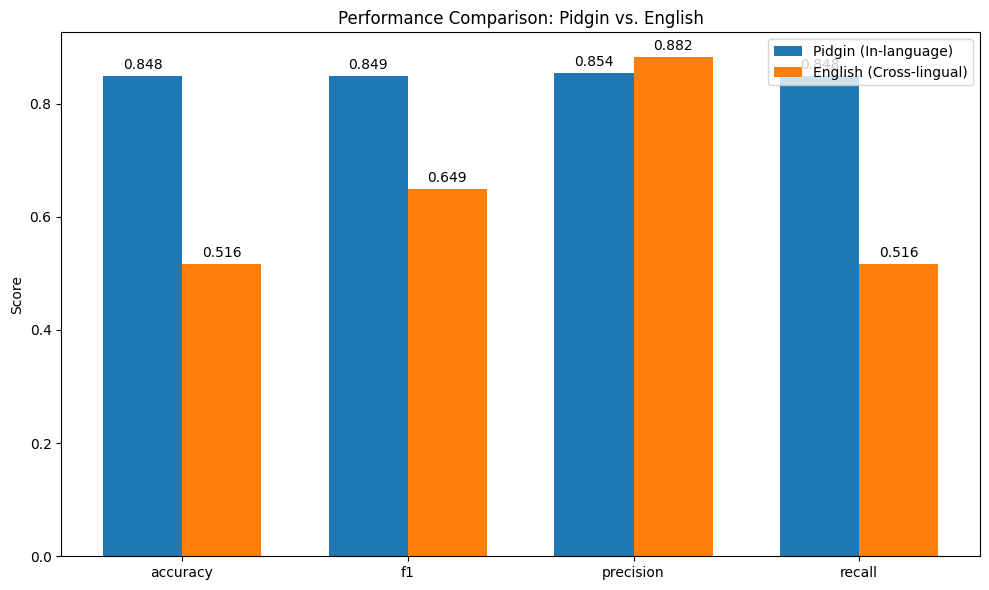

In [ ]:
# Plot performance comparison
plot_performance_comparison(pidgin_test_results, english_test_results)

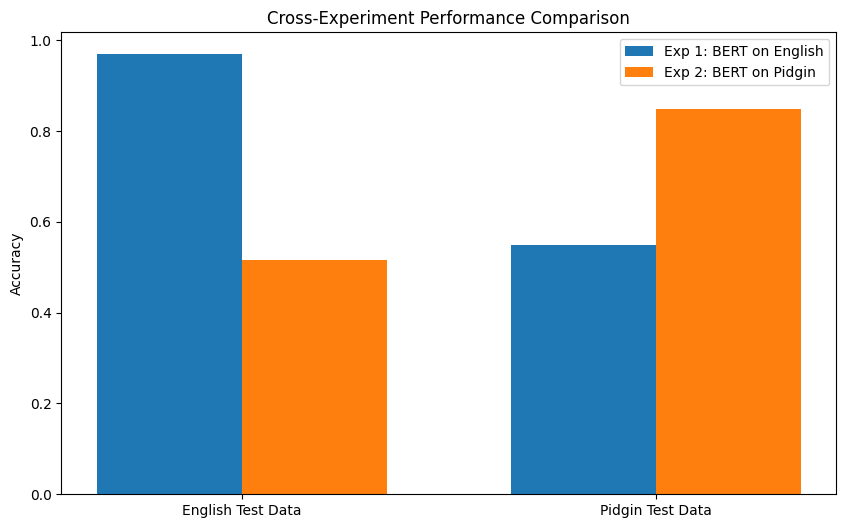

In [ ]:
# ## 12. Compare to Experiment 1 Results

# You can fill in the Experiment 1 results here to create a comparison
exp1_english_accuracy = 0.9693  # From Experiment 1 results
exp1_pidgin_accuracy = 0.5493   # From Experiment 1 results

exp2_english_accuracy = english_test_results['eval_accuracy']
exp2_pidgin_accuracy = pidgin_test_results['eval_accuracy']

# Create comparison chart
labels = ['English Test Data', 'Pidgin Test Data']
exp1_scores = [exp1_english_accuracy, exp1_pidgin_accuracy]
exp2_scores = [exp2_english_accuracy, exp2_pidgin_accuracy]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, exp1_scores, width, label='Exp 1: BERT on English')
rects2 = ax.bar(x + width/2, exp2_scores, width, label='Exp 2: BERT on Pidgin')

ax.set_ylabel('Accuracy')
ax.set_title('Cross-Experiment Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


In [ ]:
# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

In [ ]:
# ## 13. Save Results and Summary

# Create output directory if it doesn't exist
os.makedirs("./results/exp2", exist_ok=True)

# Save all results
results_summary = {
    'validation': val_results,
    'pidgin_test': pidgin_test_results,
    'english_test': english_test_results,
    'combined_test': combined_test_results
}

In [ ]:
# Write results to file
with open("./results/exp2/results_summary.txt", "w") as f:
    f.write("Experiment 2: BERT-base-uncased fine-tuned on Nigerian Pidgin\n")
    f.write("=============================================\n\n")

    f.write("Model: bert-base-uncased with class weights\n")
    f.write(f"Train dataset size: {len(train_dataset)}\n")
    f.write(f"Validation dataset size: {len(val_dataset)}\n")
    f.write(f"Pidgin test dataset size: {len(pidgin_test_dataset)}\n")
    f.write(f"English test dataset size: {len(english_test_dataset)}\n")
    f.write(f"Combined test dataset size: {len(combined_test_dataset)}\n\n")

    f.write("Results:\n")
    for dataset_name, results in results_summary.items():
        f.write(f"\n{dataset_name.upper()} RESULTS:\n")
        for metric, value in results.items():
            f.write(f"  {metric}: {value}\n")

print("\nExperiment completed! Results saved to ./results/exp2/results_summary.txt")



Experiment completed! Results saved to ./results/exp2/results_summary.txt
